<div style="text-align: center;">
    <p style="font-size: 50px;">Práctica 3: Recurrent Neural Networks</p>
</div>

## 1. Cargamos y examinamos los datos

In [1]:
import pandas as pd

# Cargar el archivo JSON
file_path = "USD_EUR.json"
data = pd.read_json(file_path)

# Inspeccionar las primeras filas del DataFrame
data.head()

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,timestamp final,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros
0,2020-01-03 08:00:00,1.1154,1.1200,1.1154,1.1182,37309.48,2020-01-03 08:59:59.999,41775.464275,31,20419.46,22858.822356
1,2020-01-03 09:00:00,1.1182,1.1182,1.1151,1.1151,2132.61,2020-01-03 09:59:59.999,2384.431292,5,2036.69,2277.401075
2,2020-01-03 10:00:00,1.1151,1.1172,1.1151,1.1151,1950.83,2020-01-03 10:59:59.999,2175.391533,4,10.00,11.172000
3,2020-01-03 11:00:00,1.1136,1.1151,1.1136,1.1141,310.53,2020-01-03 11:59:59.999,346.107438,4,232.00,258.656430
4,2020-01-03 12:00:00,1.1126,1.1133,1.1126,1.1133,394.52,2020-01-03 12:59:59.999,439.130428,3,0.00,0.000000


In [2]:
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp inicial,24970,2021-06-07 09:52:59.014818048,2020-01-03 08:00:00,2020-09-19 22:15:00,2021-06-07 13:30:00,2022-02-22 21:45:00,2022-11-10 00:00:00,NaN
precio inicio,24970.0,1.126497,0.9536,1.08,1.133,1.1788,1.3098,0.066949
precio mas alto,24970.0,1.127797,0.9554,1.082,1.134,1.1799,4.95,0.071274
precio mas bajo,24970.0,1.125329,0.9535,1.078,1.132,1.1777,1.2695,0.066925
precio fin,24970.0,1.126459,0.9536,1.08,1.133,1.1787,1.3098,0.066935
volumen,24970.0,1588137.883691,0.0,74407.3325,791179.35,2069755.35,46948429.81,2435378.675104
timestamp final,24970,2021-06-07 10:52:58.645466880,2020-01-03 08:59:59.999000,2020-09-19 23:14:59.999000064,2021-06-07 14:29:59.999000064,2022-02-22 22:44:59.999000064,2022-11-10 00:59:59.999000,NaN
volumen en cuotas,24970.0,1831407.156088,0.0,85584.6527,872295.517593,2302446.63875,57843832.806441,2898230.027404
numero de compras,24970.0,3249.635603,0.0,298.0,2046.0,4215.0,53917.0,4291.602485
volumen de dolares,24970.0,741296.753644,0.0,31896.42,335917.45,950988.9,23544369.72,1189478.089056


### A partir del estudio de los datos, hemos decidido comprobar la posibilidad de las siguientes inconsistencias:

1. **Inconsistencia en los precios:**
   - Verificar si los valores de `precio inicio`, `precio más alto`, `precio más bajo` y `precio fin` siguen una relación lógica entre sí.

2. **Inconsistencia entre variación de precios y número de compras igual a 0 o volumen igual a 0:**
   - Comprobar si existen registros donde los precios varíen pero el número de compras y el volumen total sean 0.

3. **Inconsistencia entre volumen en euros y dólares y volumen igual a 0 o número de compras igual a 0:**
   - Identificar si hay casos donde los volúmenes en euros o dólares tengan valores positivos mientras que el volumen total y el número de compras sean 0.

4. **Valores atípicos de precio más alto:**
   - Detectar registros con valores significativamente altos en la columna `precio más alto`, que podrían representar outliers.

  
  

In [3]:
# 1. Inconsistencia en los precios
price_consistency = ((data['precio mas alto'] >= data['precio mas bajo']) &
                     (data['precio inicio'] >= data['precio mas bajo']) &
                     (data['precio mas alto'] >= data['precio inicio']) &
                     (data['precio mas alto'] >= data['precio fin']) &
                     (data['precio mas bajo'] <= data['precio fin'])).all()

# 2. Inconsistencia entre variación de precios y número de compras igual a 0 o volumen igual a 0
price_variation_with_zero_operations = data[(data['numero de compras'] == 0) &
                                            (data['volumen'] == 0) &
                                            ((data['precio inicio'] != data['precio fin']) |
                                             (data['precio mas alto'] != data['precio mas bajo']))]

# 3. Inconsistencia entre volúmenes en euros/dólares y volumen igual a 0 o número de compras igual a 0
volume_with_zero_operations = data[(data['numero de compras'] == 0) &
                                    (data['volumen'] == 0) &
                                    ((data['volumen de dolares'] > 0) | (data['volumen de euros'] > 0))]


# Resumen de los resultados
results_analysis = {
    "Consistencia en los precios (True=Consistente)": price_consistency,
    "Inconsistencias con número de compras y volumen igual a 0": price_variation_with_zero_operations.shape[0],
    "Inconsistencias con volúmenes en euros/dólares y operaciones igual a 0": volume_with_zero_operations.shape[0],
}

results_analysis


{'Consistencia en los precios (True=Consistente)': True,
 'Inconsistencias con número de compras y volumen igual a 0': 0,
 'Inconsistencias con volúmenes en euros/dólares y operaciones igual a 0': 0}

In [4]:
# Calcular los 5 valores más altos de "precio mas alto"
top_5_precio_max = data.nlargest(5, 'precio mas alto')

# Mostrar los 5 valores más altos
print("Top 5 valores más altos de 'precio mas alto':")
print(top_5_precio_max[['timestamp inicial', 'precio mas alto']])

# Eliminar el registro correspondiente al máximo de estos valores en `data`
data = data[data['precio mas alto'] != top_5_precio_max.iloc[0]['precio mas alto']]

# Verificar que el registro ha sido eliminado
print("\nDescripción de 'precio mas alto' tras la eliminación:")
print(data['precio mas alto'].describe())

Top 5 valores más altos de 'precio mas alto':
        timestamp inicial  precio mas alto
86    2020-01-06 22:00:00           4.9500
12020 2021-05-19 05:00:00           1.5000
12026 2021-05-19 11:00:00           1.3397
8755  2021-01-02 21:00:00           1.3345
8754  2021-01-02 20:00:00           1.3340

Descripción de 'precio mas alto' tras la eliminación:
count    24969.000000
mean         1.127644
std          0.067045
min          0.955400
25%          1.082000
50%          1.134000
75%          1.179900
max          1.500000
Name: precio mas alto, dtype: float64


### Calculamos si existen registros faltantes

In [5]:
# Calcular la diferencia de tiempo entre registros consecutivos
data['delta_t'] = data['timestamp inicial'].diff().dt.total_seconds() / 3600  # Diferencia en horas

# Identificar registros con saltos mayores a 1 hora
registros_faltantes = data[data['delta_t'] > 1].copy()

# Calcular el número de registros faltantes para cada salto
registros_faltantes['registros_faltantes'] = registros_faltantes['delta_t'] - 1

# Verificar los registros faltantes
print(registros_faltantes[['timestamp inicial', 'delta_t', 'registros_faltantes']])

        timestamp inicial  delta_t  registros_faltantes
87    2020-01-06 23:00:00      2.0                  1.0
882   2020-02-09 03:00:00      2.0                  1.0
1131  2020-02-19 17:00:00      6.0                  5.0
1460  2020-03-04 11:00:00      2.0                  1.0
2699  2020-04-25 04:00:00      3.0                  2.0
4233  2020-06-28 05:00:00      4.0                  3.0
7954  2020-11-30 07:00:00      2.0                  1.0
8465  2020-12-21 18:00:00      5.0                  4.0
8545  2020-12-25 03:00:00      2.0                  1.0
9698  2021-02-11 05:00:00      2.0                  1.0
10247 2021-03-06 03:00:00      2.0                  1.0
11326 2021-04-20 04:00:00      3.0                  2.0
11447 2021-04-25 08:00:00      4.0                  3.0
14081 2021-08-13 06:00:00      5.0                  4.0
15210 2021-09-29 09:00:00      3.0                  2.0


### Manejo de datos faltantes

Dado que existen datos faltantes, hemos decidido aplicar **interpolaciones lineales** para rellenar los registros faltantes, calculando valores intermedios basados en los registros anteriores y posteriores.


In [6]:
# Crear un índice completo con intervalos de 1 hora usando 'h' en lugar de 'H'
full_range = pd.date_range(start=data['timestamp inicial'].min(), 
                           end=data['timestamp inicial'].max(), freq='h')

# Ajustar el índice y rellenar datos faltantes
data = data.set_index('timestamp inicial').reindex(full_range).interpolate().reset_index()
data.rename(columns={'index': 'timestamp inicial'}, inplace=True)
data = data.drop(columns=['delta_t'], errors='ignore')

In [7]:
# Calcular diferencias de tiempo antes de interpolar
discontinuidades = data['timestamp inicial'].diff() > pd.Timedelta(hours=1)
print("Número de discontinuidades:", discontinuidades.sum())

Número de discontinuidades: 0


### Generamos las siguientes variables y las añadimos al dataframe:

1. **`binary`:**
   - Es una variable binaria que toma el valor:
     - **0** si el precio inicio del registro actual es menor al precio inicio del registro 6 horas antes.
     - **1** si el precio inicio del registro actual es mayor al precio inicio del registro 6 horas antes.

2. **`Tasas de variación:`**
   - Para cada columna de precios (`precio inicio`, `precio más alto`, `precio más bajo`, `precio fin`), calculamos la **tasa de variación porcentual** respecto al registro inmediatamente anterior.
   - Las nuevas columnas generadas son:
     - `tasa_precio inicio`: Tasa de variación del precio inicio.
     - `tasa_precio mas alto`: Tasa de variación del precio más alto.
     - `tasa_precio mas bajo`: Tasa de variación del precio más bajo.
     - `tasa_precio fin`: Tasa de variación del precio fin.

   - Fórmula utilizada:
     ```math
     \text{Tasa de variación} = \frac{\text{Valor actual} - \text{Valor anterior}}{\text{Valor anterior}} \times 100
     ```

   - Las tasas ayudan a capturar cambios relativos en los precios entre registros consecutivos y en combinación con variables como `binary`, capturan el comportamiento dinámico de los precios, lo que es esencial para predecir si la dirección del precio será positiva o negativa.



In [8]:
data['binary'] = (data['precio inicio'] > data['precio inicio'].shift(6)).astype(int)

In [9]:


# Calcular tasas de variación respecto al registro anterior para cada precio
for col in ['precio inicio', 'precio mas alto', 'precio mas bajo', 'precio fin']:
    data[f'tasa_{col}'] = data[col].pct_change() * 100


# Eliminar filas con NaN generados por el cálculo de tasas o etiquetas
data = data.dropna(subset=[f'tasa_{col}' for col in ['precio inicio', 'precio mas alto', 'precio mas bajo', 'precio fin']])


# Verificar los resultados de `data_modelo_direccional` 
data.head()


,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,timestamp final,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,binary,tasa_precio inicio,tasa_precio mas alto,tasa_precio mas bajo,tasa_precio fin
1,2020-01-03 09:00:00,1.1182,1.1182,1.1151,1.1151,2132.61,2020-01-03 09:59:59.999,2384.431292,5.0,2036.69,2277.401075,0,0.251031,-0.160714,-0.026896,-0.277231
2,2020-01-03 10:00:00,1.1151,1.1172,1.1151,1.1151,1950.83,2020-01-03 10:59:59.999,2175.391533,4.0,10.00,11.172000,0,-0.277231,-0.089429,0.000000,0.000000
3,2020-01-03 11:00:00,1.1136,1.1151,1.1136,1.1141,310.53,2020-01-03 11:59:59.999,346.107438,4.0,232.00,258.656430,0,-0.134517,-0.187970,-0.134517,-0.089678
4,2020-01-03 12:00:00,1.1126,1.1133,1.1126,1.1133,394.52,2020-01-03 12:59:59.999,439.130428,3.0,0.00,0.000000,0,-0.089799,-0.161421,-0.089799,-0.071807
5,2020-01-03 13:00:00,1.1141,1.1174,1.1141,1.1171,2093.90,2020-01-03 13:59:59.999,2335.519448,17.0,1634.99,1824.009728,0,0.134819,0.368274,0.134819,0.341328


### Partición entre conjunto de entrenamiento y conjunto de test

Realizamos la partición de los datos en dos conjuntos:

1. **Conjunto de entrenamiento:**
   - Contiene los registros utilizados para entrenar el modelo.

2. **Conjunto de test:**
   - Incluye los registros utilizados para evaluar el rendimiento del modelo en datos no vistos.

La partición se realiza utilizando una fecha de corte predefinida, dividiendo los datos en función de la columna temporal `timestamp inicial`.


In [10]:
#Partición entre conjunto de entrenamiento y conjunto de test
# Convertir timestamp inicial a datetime para facilitar partición
data['timestamp inicial'] = pd.to_datetime(data['timestamp inicial'])

# Definir la fecha de corte para partición
fecha_corte = pd.Timestamp("2022-09-01 00:00:00")

# Dividir los datos en entrenamiento y prueba
train_data = data[data['timestamp inicial'] < fecha_corte]
test_data = data[data['timestamp inicial'] >= fecha_corte]

# Mostrar información de los conjuntos
print(f"Conjunto de entrenamiento: {train_data.shape[0]} registros")
print(f"Conjunto de test: {test_data.shape[0]} registros")

Conjunto de entrenamiento: 23319 registros
Conjunto de test: 1681 registros


## 2. Preprocesado

### Transformamos de la variable temporal y generamos de características cíclicas

In [11]:
import numpy as np

# Eliminar la columna 'timestamp final' si existe
train_data = train_data.drop(columns=['timestamp final'], errors='ignore')
test_data = test_data.drop(columns=['timestamp final'], errors='ignore')

# Convertir 'timestamp inicial' a formato datetime
data['timestamp inicial'] = pd.to_datetime(data['timestamp inicial'])

# Convertir 'timestamp inicial' en segundos desde el epoch
timestamp_s_train = train_data['timestamp inicial'].map(pd.Timestamp.timestamp)
timestamp_s_test = test_data['timestamp inicial'].map(pd.Timestamp.timestamp)

# Calcular el número de segundos de un día y un año
day = 24 * 60 * 60  # Segundos en un día
year = 365.25 * day  # Segundos en un año (considerando años bisiestos)

# Extraer seno y coseno para el ciclo diario y anual
for df, timestamp_s in zip([train_data, test_data], [timestamp_s_train, timestamp_s_test]):
    df['Dia sin'] = np.sin(2 * np.pi * timestamp_s / day)
    df['Dia cos'] = np.cos(2 * np.pi * timestamp_s / day)
    df['Anho sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Anho cos'] = np.cos(2 * np.pi * timestamp_s / year)

# Verificar las nuevas columnas en el conjunto de entrenamiento
train_data[['timestamp inicial', 'Dia sin', 'Dia cos', 'Anho sin', 'Anho cos']].head()


,timestamp inicial,Dia sin,Dia cos,Anho sin,Anho cos
1,2020-01-03 09:00:00,7.071068e-01,-0.707107,0.032249,0.999480
2,2020-01-03 10:00:00,5.000000e-01,-0.866025,0.032965,0.999456
3,2020-01-03 11:00:00,2.588190e-01,-0.965926,0.033682,0.999433
4,2020-01-03 12:00:00,4.199953e-12,-1.000000,0.034398,0.999408
5,2020-01-03 13:00:00,-2.588190e-01,-0.965926,0.035114,0.999383


### Estandarización de las variables numéricas

1. **Proceso:**
   - Se calcularon la media y desviación estándar en el **conjunto de entrenamiento**.
   - Las columnas seleccionadas se escalaron con estos parámetros para garantizar una distribución centrada en 0 y desviación estándar de 1.

2. **Aplicación:**
   - Las mismas estadísticas del entrenamiento se aplicaron al conjunto de prueba.

3. **Columnas estandarizadas:**
   - `precio inicio`, `precio mas alto`, `precio mas bajo`, `precio fin`, `volumen`, `volumen en cuotas`, `numero de compras`, `volumen de dolares`, `volumen de euros`.


In [12]:
# Seleccionar las columnas numéricas que serán normalizadas
columns_to_normalize = ['precio inicio', 'precio mas alto', 'precio mas bajo', 'precio fin',
                        'volumen', 'volumen en cuotas', 'numero de compras', 'volumen de dolares', 'volumen de euros']

# Calcular la media y desviación estándar del conjunto de entrenamiento
mean_train = train_data[columns_to_normalize].mean()
std_train = train_data[columns_to_normalize].std()


train_data[columns_to_normalize] = (train_data[columns_to_normalize] - mean_train) / std_train
test_data[columns_to_normalize] = (test_data[columns_to_normalize] - mean_train) / std_train

# Verificar la normalización en el conjunto de entrenamiento
train_data[columns_to_normalize].head(15)
train_data = train_data.drop(columns=['timestamp inicial'], errors='ignore')
test_data = test_data.drop(columns=['timestamp inicial'], errors='ignore')

### Ahora podemos observar como los datos están más o menos todos en la misma escala.

C:\Users\34649\AppData\Local\Temp\ipykernel_14964\1022011392.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(train_data.keys(), rotation=90)


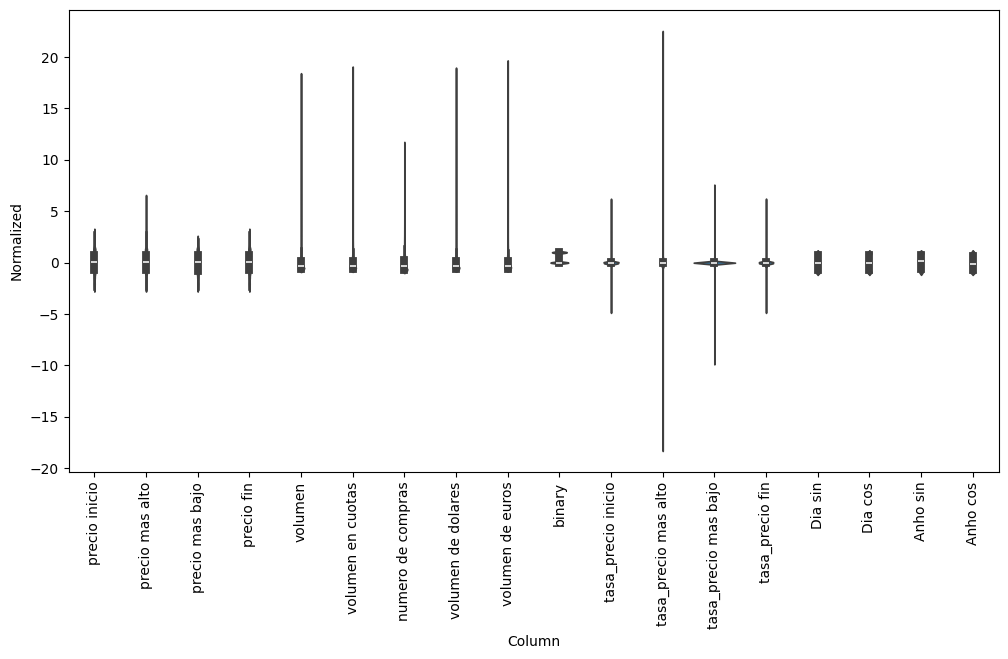

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_std = train_data.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_data.keys(), rotation=90)

In [15]:
test_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
precio inicio,1681.0,-2.602664e+00,0.219412,-3.188590,-2.782545,-2.583880e+00,-2.434009,-2.062818
precio mas alto,1681.0,-2.606437e+00,0.218764,-3.174523,-2.781065,-2.587818e+00,-2.436355,-2.075975
precio mas bajo,1681.0,-2.594305e+00,0.219651,-3.167485,-2.777375,-2.580579e+00,-2.423839,-2.072044
precio fin,1681.0,-2.602434e+00,0.219386,-3.188399,-2.780545,-2.583590e+00,-2.435439,-2.062444
volumen,1681.0,-1.095120e-01,0.497966,-0.621224,-0.425881,-2.527446e-01,0.078325,5.233281
volumen en cuotas,1681.0,-1.856900e-01,0.410854,-0.608904,-0.448667,-3.044763e-01,-0.032537,4.091840
numero de compras,1681.0,-1.662482e-01,0.392660,-0.685801,-0.469872,-1.959396e-01,0.053749,4.903419
volumen de dolares,1681.0,-8.990947e-02,0.509654,-0.601329,-0.405267,-2.213861e-01,0.078021,6.150233
volumen de euros,1681.0,-1.657349e-01,0.420686,-0.589602,-0.426681,-2.747907e-01,-0.024662,4.837459
binary,1681.0,4.669839e-01,0.499057,0.000000,0.000000,0.000000e+00,1.000000,1.000000


### Manejo de datos atípicos

- Identificamos la presencia de datos atípicos en las columnas relacionadas con volúmenes y tasas de variación.

#### Proceso de recorte:
1. **Columnas afectadas:**
   - Volúmenes: `volumen`, `volumen en cuotas`, `volumen de dolares`, `volumen de euros`.
   - Tasa de variación: `tasa_precio mas alto`.

2. **Definición de límites:**
   - **Volúmenes:** Recortados al percentil **99%**.
   - **Tasa de variación:** Recortada entre los percentiles **1% y 99%**.

3. **Implementación:**
   - Los valores superiores al límite en volúmenes fueron ajustados al límite superior.
   - Los valores extremos (tanto superiores como inferiores) en `tasa_precio mas alto` fueron ajustados a los límites correspondientes.

#### Resultado:
- Las columnas afectadas muestran ahora distribuciones más controladas, reduciendo el impacto de valores atípicos.


In [16]:
## Definir las columnas de volúmenes y tasa a recortar
columns_to_clip_volumes = ['volumen', 'volumen en cuotas', 'volumen de dolares', 'volumen de euros']
column_tasa = 'tasa_precio mas alto'

# Calcular los límites superiores para los volúmenes (percentil 99)
clip_limits_volumes = train_data[columns_to_clip_volumes].quantile(0.99)

# Calcular los límites inferior y superior para la tasa de precio más alto (percentiles 1% y 99%)
clip_limits_tasa = train_data[column_tasa].quantile([0.01, 0.99])

# Recortar valores extremos en volúmenes
for col in columns_to_clip_volumes:
    train_data[col] = train_data[col].clip(upper=clip_limits_volumes[col])
    test_data[col] = test_data[col].clip(upper=clip_limits_volumes[col])

# Recortar valores extremos en 'tasa_precio mas alto' (tanto inferior como superior)
train_data[column_tasa] = train_data[column_tasa].clip(lower=clip_limits_tasa.iloc[0], upper=clip_limits_tasa.iloc[1])
test_data[column_tasa] = test_data[column_tasa].clip(lower=clip_limits_tasa.iloc[0], upper=clip_limits_tasa.iloc[1])

# Verificar el impacto de los cambios
train_data[columns_to_clip_volumes + [column_tasa]].describe()

,volumen,volumen en cuotas,volumen de dolares,volumen de euros,tasa_precio mas alto
count,23319.000000,23319.000000,23319.000000,23319.000000,23319.000000
mean,-0.018776,-0.018970,-0.019433,-0.019627,-0.000989
std,0.872423,0.870046,0.863269,0.861005,0.106094
min,-0.642960,-0.627136,-0.613680,-0.599677,-0.368201
25%,-0.620142,-0.605224,-0.593684,-0.580511,-0.037120
50%,-0.337948,-0.339513,-0.351802,-0.352193,0.000000
75%,0.201373,0.175060,0.178554,0.154851,0.033228
max,3.969931,4.006571,3.940590,3.976572,0.374012


### Eliminación de variables:

1. **`numero de compras`:**
   - **Motivo de eliminación:**
     - Presenta alta correlación con otras variables como `volumen`, lo que puede redundar en información similar para el modelo.
     - Eliminarla reduce la dimensionalidad del problema sin pérdida significativa de información.

2. **`volumen en cuotas`:**
   - **Motivo de eliminación:**
     - Esta variable es derivada directamente de `volumen`, lo que introduce redundancia en los datos.
     - La presencia de ambas variables puede causar problemas de multicolinealidad en el modelo, dificultando el aprendizaje.


- Eliminar estas variables ayuda a simplificar el modelo, evitando redundancias y posibles problemas de sobreajuste, además de mejorar la eficiencia del entrenamiento.


In [17]:
train_data = train_data.drop(columns=['numero de compras'], errors='ignore')
test_data = test_data.drop(columns=['numero de compras'], errors='ignore')
train_data = train_data.drop(columns=['volumen en cuotas'], errors='ignore')
test_data = test_data.drop(columns=['volumen en cuotas'], errors='ignore')

### Ahora volvemos a observar los datos para comprobar que se han reducido los datos atípicos.

C:\Users\34649\AppData\Local\Temp\ipykernel_14964\1022011392.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(train_data.keys(), rotation=90)


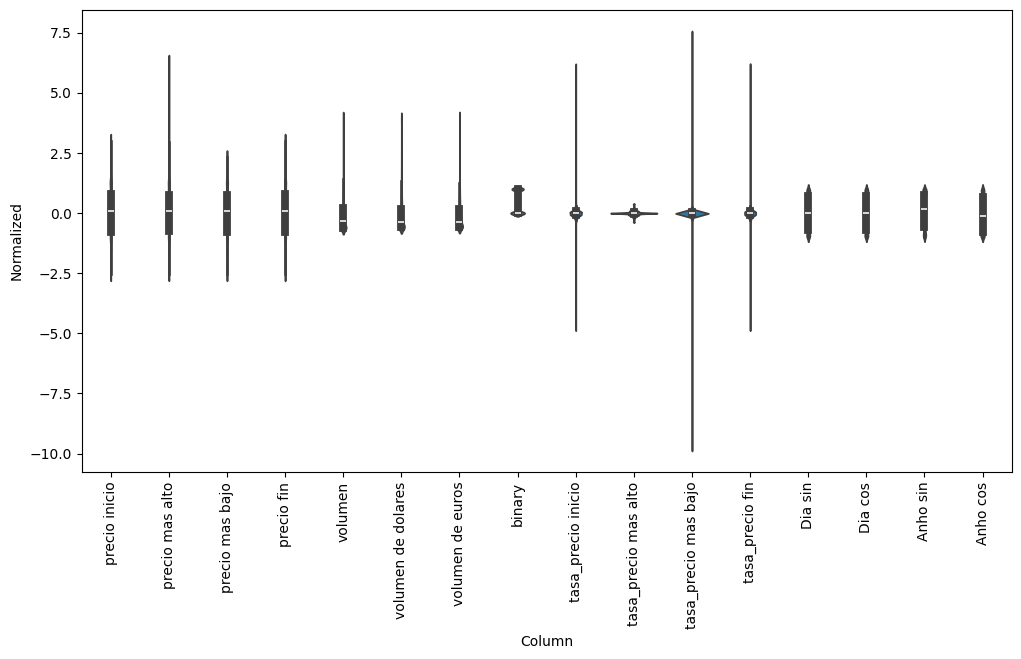

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_std = train_data.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_data.keys(), rotation=90)

### Transformación y ventanas deslizantes

1. **Conversión a NumPy:**
   - Transformamos los conjuntos de entrenamiento y prueba en arreglos NumPy.

2. **Generación de ventanas:**
   - Utilizamos la función `sliding_window` para dividir las series temporales en ventanas deslizantes.
   - Las ventanas generan pares de entrada y etiqueta.

3. **Tamaño configurable:**
   - El tamaño de la ventana se configuró como un parámetro ajustable para optimizar el modelo.


In [57]:
def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x, y = [], []
 
    for i in range(len(data) - input_width - label_width + 1 - offset):
        # Crear ventana de entrada
        _x = data[i : i + input_width]
        # Crear ventana de salida
        _y = labels[i + input_width + offset : i + input_width + offset + label_width]
       
        # Añadir a las listas principales
        x.append(_x)
        y.append(_y)
       

 
    # Convertir a numpy arrays
    x, y = np.array(x), np.array(y)
 
    # Ajustar dimensiones si es necesario
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if len(y.shape) == 2:
        y = y[:, :, np.newaxis]
   
    return x, y
 
input_width = 3

# Prueba el código
x_train, y_train = sliding_window(train_data, train_data["precio inicio"], input_width, label_width=1, offset=5)
x_test, y_test = sliding_window(test_data, test_data["precio inicio"], input_width, label_width=1, offset=5)

x_train_bool, y_train_bool = sliding_window(train_data, train_data["binary"], input_width, label_width=1, offset=5)
x_test_bool, y_test_bool = sliding_window(test_data, test_data["binary"], input_width, label_width=1, offset=5)

Para comprobar que todos los datos tiene la dimension necesaria, imprimimos sus formas

In [58]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(23311, 3, 16) (23311, 1, 1) (1673, 3, 16) (1673, 1, 1)


Nos cargamos la dimension que no vamos a utilizar

In [59]:
y_train = y_train.squeeze(axis=-1)
y_test = y_test.squeeze(axis=-1)

In [60]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(23311, 3, 16) (23311, 1) (1673, 3, 16) (1673, 1)


Lo mismo para los datos para los modelos booleanos

In [61]:
print(x_train_bool.shape, y_train_bool.shape, x_test_bool.shape, y_test_bool.shape)

(23311, 3, 16) (23311, 1, 1) (1673, 3, 16) (1673, 1, 1)


In [62]:
y_train_bool = y_train_bool.squeeze(axis=-1)
y_test_bool = y_test_bool.squeeze(axis=-1)

In [63]:
print(x_train_bool.shape, y_train_bool.shape, x_test_bool.shape, y_test_bool.shape)

(23311, 3, 16) (23311, 1) (1673, 3, 16) (1673, 1)


Primero creamos dos modelos de redes neuronales densas para predecir el precio exacto y para predecir de forma independiente si subirá o bajará (esto es útil porque puede servir como medida de confianza), lo usaremos como punto de referencia para los modelos recurrentes.

In [64]:
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

# Definir el modelo totalmente conectado (MLP)
def create_mlp(input_shape):
    # Define la entrada del modelo
    inputs = tf.keras.Input(shape=input_shape)

    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    outputs = Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

def create_bi_mlp(input_shape):
    # Define la entrada del modelo
    inputs = tf.keras.Input(shape=input_shape)
    
    # Capas ocultas
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    
    # Capa de salida con activación sigmoide para predicción booleana
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [65]:
# Crear el modelo mlp
model = create_mlp(input_shape = x_train.shape[1:])

# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test mae: {test_mae}")

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0375 - mae: 0.0879
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 0.0040 - mae: 0.0446
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 0.0038 - mae: 0.0425
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0039 - mae: 0.0428
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 0.0033 - mae: 0.0397
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 0.0035 - mae: 0.0412
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - loss: 0.0034 - mae: 0.0395
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 0.0030 - mae: 0.0386
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - loss: 0.0030 - mae: 0.0391
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.0031 - mae: 0.0388
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - loss: 0.0030 - mae: 0.0386
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - loss: 0.0030 - mae: 0.0385
E

In [66]:
# Crear el modelo binary
model = create_bi_mlp(input_shape = x_train.shape[1:])

# Entrenar el modelo
history = model.fit(x_train_bool, y_train_bool, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test_bool, y_test_bool)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.5810 - loss: 0.6742
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.6346 - loss: 0.6415
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.6480 - loss: 0.6288
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.6453 - loss: 0.6273
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.6607 - loss: 0.6180
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.6587 - loss: 0.6164
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.6690 - loss: 0.6102
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.6661 - loss: 0.6084
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.6633 - loss: 0.6084
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.6748 - loss: 0.6039
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.6801 - loss: 0.5985
Epoch 12/20
729/729 ━━━━━━━━━━

Lo siguiente es un modelo de red neuronal recurrente LSTM (Long Short Term Memory). Este tipo de modelos pueden recordar datos que usarán paara las predicciones. Esperamos que esto pueda mejorar las métricas del modelo.

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    x = LSTM(128, activation='tanh')(inputs)  # 128 unidades LSTM
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)     

    numeric_output = Dense(1, activation='linear', name="numeric_output")(x)
    
    # Crear el modelo con solo la salida numérica
    model = tf.keras.Model(inputs=inputs, outputs=numeric_output)
    
    # Compilar el modelo con pérdidas y métricas para la salida numérica
    model.compile(
        optimizer='adam',
        loss='mse',  # Pérdida para la salida numérica (MSE)
        metrics=['mae']  # Métrica para la salida numérica (MAE)
    )
    
    return model

def create_bi_lstm(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    x = LSTM(128, activation='tanh')(inputs)  # 128 unidades LSTM
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)        
 
    boolean_output = Dense(1, activation='sigmoid', name="boolean_output")(x)
    
    # Crear el modelo con solo la salida booleana
    model = tf.keras.Model(inputs=inputs, outputs=boolean_output)
    
    # Compilar el modelo con pérdidas y métricas para la salida booleana
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Pérdida para la salida booleana (BCE)
        metrics=['accuracy']  # Métrica para la salida booleana (accuracy)
    )
    
    return model


In [68]:
lstm_model = create_lstm(input_shape=x_train.shape[1:])
#ltsm_model.summary()

# Entrenar el modelo
history = lstm_model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = lstm_model.evaluate(x_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("MAE en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0548 - mae: 0.1067
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - mae: 0.0429
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - mae: 0.0422
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - mae: 0.0440
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0036 - mae: 0.0423
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - mae: 0.0428
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - mae: 0.0413
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - mae: 0.0406
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0035 - mae: 0.0409
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - mae: 0.0404
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - mae: 0.0398
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - mae: 0.0399
Epoch 13/20
729/729 ━━━━━

In [69]:
lstm_bi_model = create_bi_lstm(input_shape=x_train.shape[1:])
#ltsm_bi_model.summary()

# Entrenar el modelo
history = lstm_bi_model.fit(x_train_bool, y_train_bool, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = lstm_bi_model.evaluate(x_test_bool, y_test_bool)
print("Loss en el conjunto de prueba:", test_loss)
print("Acurracy en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5734 - loss: 0.6780
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6375 - loss: 0.6410
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6450 - loss: 0.6324
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6505 - loss: 0.6263
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6536 - loss: 0.6221
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6651 - loss: 0.6129
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6637 - loss: 0.6127
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6633 - loss: 0.6112
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6715 - loss: 0.6087
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6795 - loss: 0.6004
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6738 - loss: 0.6002
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Ahora probamos con la red neruonal reccurente GRU, como alternativa a LSTM (debería ejecutarse un poco más rápido, pero al ser modelos sencillos no se va a notar).

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense

def create_gru(input_shape):
    # Entrada
    inputs = Input(shape=input_shape)
    
    # Capa GRU
    x = GRU(128, activation='tanh')(inputs)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)        

    exact_output = Dense(1, activation='linear', name="exact_output")(x)
    
    
    # Definimos el modelo con dos salidas
    model = Model(inputs=inputs, outputs=exact_output)
    
    # Compilamos el modelo
    model.compile(
        optimizer='adam',
        loss='mse',  # Pérdida para la salida numérica (MSE)
        metrics=['mae']  # Métrica para la salida numérica (MAE)
    )
    
    
    return model

def create_bi_gru(input_shape):
    # Entrada
    inputs = Input(shape=input_shape)
    
    # Capa GRU
    x = GRU(128, activation='tanh')(inputs)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)       

    boolean_output = Dense(1, activation='sigmoid', name="boolean_output")(x)
    
    # Definimos el modelo con dos salidas
    model = Model(inputs=inputs, outputs= boolean_output)
    
    # Compilamos el modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Pérdida para la salida booleana (BCE)
        metrics=['accuracy']  # Métrica para la salida booleana (accuracy)
    )
    
    return model


In [71]:
gru_model = create_gru(input_shape=x_train.shape[1:])
#ltsm_model.summary()

# Entrenar el modelo
history = lstm_model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = lstm_model.evaluate(x_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("MAE en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0029 - mae: 0.0375
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - mae: 0.0363
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - mae: 0.0373
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0028 - mae: 0.0373
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - mae: 0.0376
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - mae: 0.0368
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - mae: 0.0365
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - mae: 0.0366
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - mae: 0.0352
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - mae: 0.0364
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0024 - mae: 0.0348
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - mae: 0.0363
Epoch 13/20
729/729 ━━━━━

In [72]:
bi_gru_model = create_bi_gru(input_shape=x_train.shape[1:])
#ltsm_bi_model.summary()

# Entrenar el modelo
history = bi_gru_model.fit(x_train_bool, y_train_bool, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = bi_gru_model.evaluate(x_test_bool, y_test_bool)
print("Loss en el conjunto de prueba:", test_loss)
print("Acurracy en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5786 - loss: 0.6733
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6405 - loss: 0.6363
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6439 - loss: 0.6322
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6452 - loss: 0.6277
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6515 - loss: 0.6218
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6624 - loss: 0.6150
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6624 - loss: 0.6147
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6725 - loss: 0.6080
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6761 - loss: 0.6065
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6721 - loss: 0.6023
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6812 - loss: 0.5989
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

El aplicar modelos con memoria (Redes Neuronales Recurrentes) se ha notado una mejora, y en bolsa los precios anteriores afectan a los precios futuros así que tiene sentido. POr tanto, sería buena idea aplicar modelos anidados ya que mejoraran su memoria (lo haremos tanto para LSTM como para GRU)

In [73]:
import tensorflow as tf
def create_nested_lstm(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    
    # Primera capa LSTM (devuelve secuencias para permitir la entrada a otra LSTM)
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    
    # Segunda capa LSTM
    x = LSTM(64, activation='tanh')(x)
    
    # Capa densa oculta
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x) 
    
    # Salida numérica
    numeric_output = Dense(1, activation='linear', name="numeric_output")(x)
    
    # Crear el modelo con salida numérica
    model = tf.keras.Model(inputs=inputs, outputs=numeric_output)
    
    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='mse',  # Pérdida para la salida numérica
        metrics=['mae']  # Métrica para la salida numérica
    )
    
    return model

def create_nested_bi_lstm(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    
    # Primera capa LSTM (devuelve secuencias para permitir la entrada a otra LSTM)
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    
    # Segunda capa LSTM
    x = LSTM(64, activation='tanh')(x)
    
    # Capa densa oculta
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x) 
    
    # Salida booleana
    boolean_output = Dense(1, activation='sigmoid', name="boolean_output")(x)
    
    # Crear el modelo con salida booleana
    model = tf.keras.Model(inputs=inputs, outputs=boolean_output)
    
    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Pérdida para la salida booleana
        metrics=['accuracy']  # Métrica para la salida booleana
    )
    
    return model

In [76]:
ltsm_nested_model = create_nested_lstm(input_shape=x_train.shape[1:])

# Entrenar el modelo
history = ltsm_nested_model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = ltsm_nested_model.evaluate(x_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("MAE en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0774 - mae: 0.1288
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - mae: 0.0445
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0036 - mae: 0.0433
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0036 - mae: 0.0431
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - mae: 0.0443
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0040 - mae: 0.0450
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0407
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0031 - mae: 0.0400
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - mae: 0.0422
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0031 - mae: 0.0404
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0406
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0404
Epoch 13/20
729/729 ━━━━━

In [78]:
bi_ltsm_nested_model = create_bi_lstm(input_shape=x_train.shape[1:])
#ltsm_bi_model.summary()

# Entrenar el modelo
history = bi_ltsm_nested_model.fit(x_train_bool, y_train_bool, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = bi_ltsm_nested_model.evaluate(x_test_bool, y_test_bool)
print("Loss en el conjunto de prueba:", test_loss)
print("Acurracy en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5736 - loss: 0.6770
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6350 - loss: 0.6403
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6429 - loss: 0.6335
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6492 - loss: 0.6262
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6554 - loss: 0.6231
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6606 - loss: 0.6152
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6647 - loss: 0.6146
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6608 - loss: 0.6141
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6671 - loss: 0.6083
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6710 - loss: 0.6056
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6722 - loss: 0.6045
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [79]:
def create_nested_gru(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    
    # Primera capa gru (devuelve secuencias para permitir la entrada a otra gru)
    x = GRU(128, activation='tanh', return_sequences=True)(inputs)
    
    # Segunda capa gru
    x = GRU(64, activation='tanh')(x)
    
    # Capa densa oculta
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x) 
    
    # Salida numérica
    numeric_output = Dense(1, activation='linear', name="numeric_output")(x)
    
    # Crear el modelo con salida numérica
    model = tf.keras.Model(inputs=inputs, outputs=numeric_output)
    
    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='mse',  # Pérdida para la salida numérica
        metrics=['mae']  # Métrica para la salida numérica
    )
    
    return model

def create_nested_bi_gru(input_shape):
    # Definir entrada y cuerpo del modelo
    inputs = tf.keras.Input(shape=input_shape)
    
    # Primera capa gru (devuelve secuencias para permitir la entrada a otra gru)
    x = GRU(128, activation='tanh', return_sequences=True)(inputs)
    
    # Segunda capa gru
    x = GRU(64, activation='tanh')(x)
    
    # Capa densa oculta
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x) 
    
    # Salida booleana
    boolean_output = Dense(1, activation='sigmoid', name="boolean_output")(x)
    
    # Crear el modelo con salida booleana
    model = tf.keras.Model(inputs=inputs, outputs=boolean_output)
    
    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Pérdida para la salida booleana
        metrics=['accuracy']  # Métrica para la salida booleana
    )
    
    return model

In [80]:
gru_nested_model = create_nested_gru(input_shape=x_train.shape[1:])

# Entrenar el modelo
history = gru_nested_model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = gru_nested_model.evaluate(x_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("MAE en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0449 - mae: 0.0987
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - mae: 0.0452
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0045 - mae: 0.0476
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0039 - mae: 0.0449
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - mae: 0.0428
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - mae: 0.0439
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0032 - mae: 0.0401
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0404
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - mae: 0.0411
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0410
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - mae: 0.0404
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0036 - mae: 0.0420
Epoch 13/20
729/729 ━━━━━

In [81]:
bi_gru_nested_model = create_bi_gru(input_shape=x_train.shape[1:])
#ltsm_bi_model.summary()

# Entrenar el modelo
history = bi_gru_nested_model.fit(x_train_bool, y_train_bool, epochs=20, batch_size=32)

# Evaluar el modelo
test_loss, test_accuracy = bi_gru_nested_model.evaluate(x_test_bool, y_test_bool)
print("Loss en el conjunto de prueba:", test_loss)
print("Acurracy en el conjunto de prueba:", test_accuracy)

Epoch 1/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5797 - loss: 0.6726
Epoch 2/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6381 - loss: 0.6408
Epoch 3/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6385 - loss: 0.6330
Epoch 4/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6580 - loss: 0.6228
Epoch 5/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6520 - loss: 0.6239
Epoch 6/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6637 - loss: 0.6169
Epoch 7/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6653 - loss: 0.6134
Epoch 8/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6638 - loss: 0.6142
Epoch 9/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6724 - loss: 0.6026
Epoch 10/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6704 - loss: 0.6058
Epoch 11/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6788 - loss: 0.5951
Epoch 12/20
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [82]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_transformer(input_shape, num_heads, ff_units):
    # Entrada
    inputs = tf.keras.Input(shape=input_shape)
    
    # Capa de Embedding 
    embedding = layers.Dense(64)(inputs) 
    
    # Bloque de Attention
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(embedding, embedding)
    attention = layers.Dropout(0.1)(attention)
    attention = layers.LayerNormalization()(attention)
    
    # Capa Feed-Forward
    ffn = layers.Dense(ff_units, activation='relu')(attention)
    ffn = layers.Dropout(0.1)(ffn)
    ffn = layers.LayerNormalization()(ffn)
    
    # Agregar una capa global de pooling 
    pooling = layers.GlobalAveragePooling1D()(ffn)
    
    # Capa de salida para regresión
    output = layers.Dense(1, activation='linear')(pooling)
    
    # Crear el modelo
    model = models.Model(inputs=inputs, outputs=output)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

def create_bi_transformer(input_shape, num_heads, ff_units):
    # Entrada
    inputs = tf.keras.Input(shape=input_shape)
    
    # Capa de Embedding (si trabajamos con secuencias discretas, aquí no es estrictamente necesario)
    embedding = layers.Dense(64)(inputs)  # Usamos Dense para representar las características
    
    # Bloque de Attention (Self-Attention)
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(embedding, embedding)
    attention = layers.Dropout(0.1)(attention)
    attention = layers.LayerNormalization()(attention)
    
    # Capa Feed-Forward (FFN)
    ffn = layers.Dense(ff_units, activation='relu')(attention)
    ffn = layers.Dropout(0.1)(ffn)
    ffn = layers.LayerNormalization()(ffn)
    
    # Agregar una capa global de pooling (Global Average Pooling)
    pooling = layers.GlobalAveragePooling1D()(ffn)
    
    # Capa de salida para clasificación binaria
    output = layers.Dense(1, activation='sigmoid')(pooling)  # Salida binaria
    
    # Crear el modelo
    model = models.Model(inputs=inputs, outputs=output)
    
    # Compilar el modelo para clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Parámetros de ejemplo
input_shape = x_train.shape[1:]  # 3 pasos temporales y 14 características (vale para regresión y clasificación binaria)
num_heads = 8  # Número de cabezas de atención
ff_units = 512  # Tamaño de la red feed-forward

# Crear el modelo
transformer_model = create_transformer(input_shape, num_heads, ff_units)

transformer_model = create_bi_transformer(input_shape, num_heads, ff_units)

Se crean baselines sencillas:
1. El último valor usado para predecir, será la predicción.
2. Las medias de los valores para predecir, será la predición.

Lo útil de tener baselines sencillas, es que podemos usarlas para compararlas con los modelos. Si no son capaces de superar el rendimiento de las baselines (aunque lo igualen), lo mejor sería quedarnos con las baselines.

In [83]:
import sklearn.metrics as metrics

# Baseline 1: ultimo precio registrado
# Baseline precio exacto
mse_1 = metrics.mean_squared_error(y_test, x_test[:, input_width-1, 0]) # valor que debería prededecir vs el predicho
mae_1 = metrics.mean_absolute_error(y_test, x_test[:, input_width-1, 0])

# Baseline booleano
bi_cross_1 = metrics.log_loss(y_test_bool.astype(bool), x_test_bool[:, input_width-1, 9].astype(bool))
bi_acc_1 = metrics.accuracy_score(y_test_bool.astype(bool), x_test_bool[:, input_width-1, 9].astype(bool))

print(f"Baseline 1: \nModelo exacto\nLoss mse: {mse_1}, \nMae: {mae_1}, \n\nModelo Binario\n binary cross: {bi_cross_1}, \n binary acc: {bi_acc_1}")

# Baseline 2: media de las X
# Baseline precio exacto
base2_x_test = x_test[:, :, 0].mean(axis=1)
mse_2 = metrics.mean_squared_error(y_test, base2_x_test)
mae_2 = metrics.mean_absolute_error(y_test, base2_x_test)

# Baseline booleano
base2_x_test_bool = x_test_bool[:, :, 9].mean(axis=1) > 0.5
bi_cross_2 = metrics.log_loss(y_test_bool.astype(bool), base2_x_test_bool)
bi_acc_2 = metrics.accuracy_score(y_test_bool.astype(bool), base2_x_test_bool)

print(f"\nBaseline 2: \nModelo exacto\nLoss mse: {mse_2}, \nMae: {mae_2}, \n\nModelo Binario\n binary cross: {bi_cross_2}, \n binary acc: {bi_acc_2}")


Baseline 1: 
Modelo exacto
Loss mse: 0.003452065926593423, 
Mae: 0.03838272970771515, 

Modelo Binario
 binary cross: 17.55862373707739, 
 binary acc: 0.5128511655708309

Baseline 2: 
Modelo exacto
Loss mse: 0.003803713842669906, 
Mae: 0.04078165031444732, 

Modelo Binario
 binary cross: 16.89074970536034, 
 binary acc: 0.5313807531380753



| Modelo                  | Tipo de Predicción | Pérdida (Loss) | Métrica (MAE/Accuracy) |
|-------------------------|--------------------|----------------|------------------------|
| MLP                     | Exacta             | 0.0045         | 0.0521                |
| MLP                     | Binaria            | 0.7161        | 0.4728                |
| LSTM                    | Exacta             | 0.0090      | 0.7912                 |
| LSTM                    | Binaria            | 0.6842         | 0.5959                 |
| GRU                     | Exacta             | 0.0036         | 0.0460                 |
| GRU                     | Binaria            | 0.7425         | 0.5791                 |
| Nested LSTM             | Exacta             | 0.0089         | 0.0728                 |
| Nested LSTM             | Binaria            | 0.7274         | 0.5953                 |
| Nested GRU              | Exacta             | 0.0068         | 0.0663                 |
| Nested GRU              | Binaria            |  0.7043         | 0.5995                 |
| Baseline 1 (Último)     | Exacta             | 0.0034         | 0.0383                 |
| Baseline 1 (Último)     | Binaria            | 17.5586        | 0.5128                 |
| Baseline 2 (Media)      | Exacta             | 0.0038         | 0.0407                 |
| Baseline 2 (Media)      | Binaria            | 16.8907        | 0.5313                 |


## Baselines
Las baselines nos dejarán medidas que tenemos que superar con todos los modelos que pretendamos usar.
1. Esta baseline trata de repetir el último valor usado para predecir, como el valor predicho. El loss y MAE está decente (ya que el precio varía poco, y entre que sube y baja, nunca se alejará demasiado del valor real).  Pero de la predicción binaria, el alto losss y el accuracy cercano al 50, nos dice que a la hora de predecir si subirá o bajará, es totalmente aleatorio.

2. La segunda baseline hace uso de la media de los valores de entreda. Para predecir el precio, pasa exactamente lo mismo que con la baseline 1. Pero para predecir si sube o si baja, mejora ligeramente el accuracy (al hacer votación de si está subiendo o bajando dentro del tamaño de ventana, puede detectar una pequeña tendencia aunque sigua cercano al azar).

## Advertencias
Para comparar los modelos, los hemos hecho todos con la misma arquitectura para poder compararlos bien

## Modelos
### MLP 
Las redes neuronales densas (MLP) no poseen la capacidad de memoria de las redes recurrentes, lo que les impide capturar dependencias temporales en los datos. Por ello, se espera que sean los modelos con peor rendimiento en comparación con los modelos recurrentes en tareas de series temporales.
### LSTM y GRU
Las redes neuronales recurrentes, como LSTM y GRU, tienen la capacidad de memorizar información a lo largo del tiempo, lo que les permite capturar patrones temporales y mejorar la precisión en las predicciones. Como se observa en la tabla, su rendimiento supera al de las redes densas, ya que pueden modelar mejor las relaciones temporales en los datos.

### Modelos anidados
Es el mismo caso que los anteriores pero al ser anidados, tienen capacidad de abstracción de datos de la memoria.